In [1]:
import matplotlib.pyplot as plt
import numpy as np

import ipywidgets as widgets       # interactive display

<class 'ModuleNotFoundError'>: No module named 'ipywidgets'

In [2]:
# use to see the more beautiful plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()

<class 'OSError'>: 'https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles

In [3]:
class STDP:

  # function for drawing a u / time plot
  def plot_volt_trace(self, v, sp):
    # call all variables we need and define them on local variable
    pars = self.default_pars()
    V_th = pars['V_th']
    dt, range_t = pars['dt'], pars['range_t']
    plt.figure(figsize=(8, 4))
    if sp.size:
      sp_num = (sp / dt).astype(int) - 1
      v[sp_num] += 20

    # settings of plot
    plt.plot(pars['range_t'], v, 'b')
    plt.axhline(V_th, 0, 1, color='k', ls='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
               loc=[1.05, 0.75])
    plt.ylim([-80, -20])


  # function for define parameters we need in this project
  def default_pars(self):
    pars = {}
    pars['V_th'] = -45.     # spike threshold
    pars['V_reset'] = -69.  # reset potential
    pars['tau_m'] = 8.     # membrane time constant
    pars['g_L'] = 10.       # leak conductance
    pars['V_L'] = -75.  # leak reversal potential [mV]
    pars['V_rest'] = -79.   # restial potential
    pars['tref'] = 0.       # refractory time
    pars['T'] = 20.  # Total duration of simulation
    pars['dt'] = .03125   # Simulation time step
    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points

    # STDP parameters
    pars['A_plus'] = 0.008  # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD
    pars['tau_stdp'] = 20.  # STDP time constant [ms]
    pars['gE_bar'] = 0.024  # max synaptic conductance
    pars['gE_init'] = 0.024  # initial synaptic conductance
    pars['VE'] = 0.  # [mV] Synapse reversal potential
    pars['tau_syn_E'] = 5.  # [ms] EPSP time constant

    return pars

  # A function to build a random spike list
  def Poisson_generator(self, rate, n, myseed=False):

    # Use pars function for using parameters
    pars = self.default_pars()


    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # Set random seed
    if myseed:
      np.random.seed(seed=myseed)
    else:
      np.random.seed()

    # Generate uniformly distributed random variables
    u_rand = np.random.rand(n, Lt)

    # Generate Poisson train
    poisson_train = 1. * (u_rand < rate * (dt / 1000.))

    return poisson_train

  # A plot which showing each neuron when spike
  def my_raster_plot(self, range_t, spike_train, n):

    # Count of neurons
    N = spike_train.shape[0]

    # n should be smaller than N:
    if n > N:
      print('The number n exceeds the size of spike trains')
      print('The number n is set to be the size of spike trains')
      n = N

    # Raster plot
    i = 0
    while i <= n:
      if spike_train[i, :].sum() > 0.:
        t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
        plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
      i += 1
    plt.xlim([range_t[0], range_t[-1]])
    plt.ylim([-0.5, n + 0.5])
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')

  # STDP plot
  def mySTDP_plot(self, time_diff, dW):
    pars = self.default_pars()
    A_plus, A_minus = pars["A_plus"], pars["A_minus"]
    plt.figure()
    plt.plot([0, 0], 'k', linestyle=':')
    plt.plot([0, 0], [-A_minus, A_plus], 'k', linestyle=':')

    plt.plot(time_diff[time_diff <= 0], dW[time_diff <= 0], 'ro')
    plt.plot(time_diff[time_diff > 0], dW[time_diff > 0], 'bo')

    plt.xlabel(r't$_{\mathrm{pre}}$ - t$_{\mathrm{post}}$ (ms)')
    plt.ylabel(r'$\Delta$W', fontsize=12)
    plt.title('Biphasic STDP', fontsize=12, fontweight='bold')
    plt.show()

  # Calculate (pre - post) based on nearest theory
  def find_nearest(self, spike_train1, spike_train2):
    index1, index2, nearest = 0, 0, 100000
    time_diff = np.ones(spike_train1.size) * 100  # list of pre - post
    for i in range(spike_train1.size):
      if spike_train1[i] == 1:
        if index1 < index2:     # When post spike after a pre
        # If the new spike is closer than the last spike, then we will save it until sees the next one is closer or not
          if nearest > i - index2:
            nearest = i - index2 + 1
          else: # If it wasn't closer than the last so save pre-past of before
            time_diff[index2 - 1] = -nearest
            nearest = 100000
        # If one neuron spike twice continuous and we have a nearest before, it goes to this if
        elif nearest != 100000:
          time_diff[index2 - 1] = nearest
          nearest = 100000
        index1 = i + 1

      # Like upside, just for another neuron
      if spike_train2[i] == 1:
        if index2 < index1:
          if nearest > i - index1:
            nearest = i - index1 + 1
          else:
            time_diff[index1 - 1] = nearest
            nearest = 0
        elif nearest != 100000:
          time_diff[index1 - 1] = -nearest
          nearest = 100000
        index2 = i + 1

    return time_diff

  # STDP weight update
  def Delta_W(self, time_diff):
    # Get parameters
    pars = self.default_pars()
    A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']
    # STDP change
    dW = np.zeros(len(time_diff))
    # Calculate dW for LTP
    idx = np.where(time_diff<=0)
    dW[idx] = A_plus * np.exp(time_diff[idx]/tau_stdp)
    # Calculate dW for LTD
    idx = np.where(time_diff>0)
    dW[idx] = -A_minus * np.exp(-time_diff[idx]/tau_stdp)

    return dW

  # Compute LTP ratio
  def generate_P(self, pre_spike_train_ex):

    pars = self.default_pars()
    # Get parameters
    A_plus, tau_stdp = pars['A_plus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # Initialize
    P = np.zeros(pre_spike_train_ex.shape)
    for it in range(Lt - 1):
      dP = - dt/tau_stdp * P[:,it] + A_plus * pre_spike_train_ex[:,it]
      # Update P
      P[:, it + 1] = P[:, it] + dP

    return P

  # Use STDP for LIF
  def run_LIF_cond_STDP(self, pre_spike_train_ex):

    # Retrieve parameters
    pars = self.default_pars()
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m = pars['tau_m']
    V_init, V_L = pars['V_rest'], pars['V_L']
    gE_bar, VE, tau_syn_E = pars['gE_bar'], pars['VE'], pars['tau_syn_E']
    gE_init = pars['gE_init']
    tref = pars['tref']
    A_minus, tau_stdp = pars['A_minus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    P = self.generate_P(pre_spike_train_ex)

    # Initialize
    tr = 0.
    v = np.zeros(Lt)
    v[0] = V_init
    M = np.zeros(Lt)
    gE = np.zeros(Lt)
    gE_bar_update = np.zeros(pre_spike_train_ex.shape)
    gE_bar_update[:, 0] = gE_init

    # simulation
    rec_spikes = []  # recording spike times
    for it in range(Lt - 1):
      if tr > 0:
        v[it] = V_reset
        tr = tr - 1
      elif v[it] >= V_th:  # reset voltage and record spike event
        rec_spikes.append(it)
        v[it] = V_reset
        M[it] = M[it] - A_minus
        gE_bar_update[:, it] = gE_bar_update[:, it] + P[:, it] * gE_bar
        id_temp = gE_bar_update[:, it] > gE_bar
        gE_bar_update[id_temp, it] = gE_bar
        tr = tref / dt

      # update the synaptic conductance
      M[it + 1] = M[it] - dt / tau_stdp * M[it]
      gE[it + 1] = gE[it] - (dt / tau_syn_E) * gE[it] + (gE_bar_update[:, it] * pre_spike_train_ex[:, it]).sum()
      gE_bar_update[:, it + 1] = gE_bar_update[:, it] + M[it] * pre_spike_train_ex[:, it] * gE_bar
      id_temp = gE_bar_update[:, it + 1] < 0
      gE_bar_update[id_temp, it + 1] = 0.

      # calculate the increment of the membrane potential
      dv = (-(v[it] - V_L) - gE[it + 1] * (v[it] - VE)) * (dt / tau_m)

      # update membrane potential
      v[it + 1] = v[it] + dv

    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes, gE, P, M, gE_bar_update

  # Draw all STDP' plot in one
  def plot_STDP(self, v, rec_spikes, gE, P, M, gE_bar_update):
    pars = self.default_pars()
    plt.figure(figsize=(12., 8))
    plt.subplot(321)
    dt, range_t = pars['dt'], pars['range_t']
    if rec_spikes.size:
      sp_num = (rec_spikes / dt).astype(int) - 1
      v[sp_num] += 10  # add artificial spikes
    plt.plot(pars['range_t'], v, 'k')
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')

    plt.subplot(322)
    # Plot the sample presynaptic spike trains
    self.my_raster_plot(pars['range_t'], pre_spike_train_ex, 2)

    plt.subplot(323)
    plt.plot(pars['range_t'], M, 'k')
    plt.xlabel('Time (ms)')
    plt.ylabel('M')

    plt.subplot(324)
    for i in range(3):
      plt.plot(pars['range_t'], P[i, :])
    plt.xlabel('Time (ms)')
    plt.ylabel('P')

    plt.subplot(325)
    for i in range(3):
      plt.plot(pars['range_t'], gE_bar_update[i, :])
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$\bar g$')

    plt.subplot(326)
    plt.plot(pars['range_t'], gE, 'r')
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$g_E$')

    plt.tight_layout()
    plt.show()

In [4]:
stdp = STDP()
pars = stdp.default_pars()

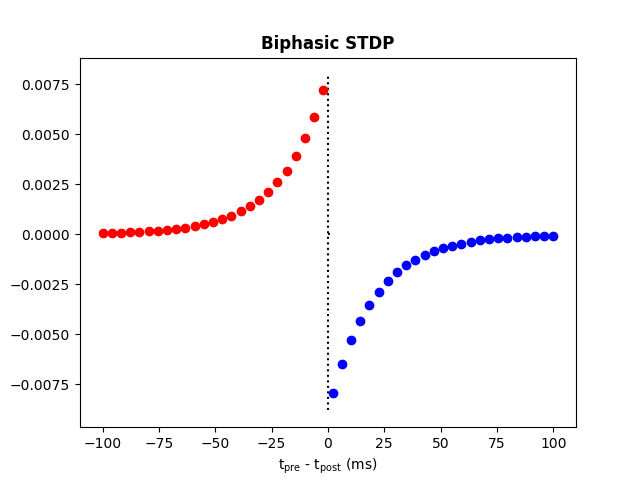

In [5]:
tau_stdp = pars['tau_stdp']
#pre_spike time - post_spike time
time_diff = np.linspace(-5 * tau_stdp, 5 * tau_stdp, 50)

dW = stdp.Delta_W(time_diff)
stdp.mySTDP_plot(time_diff, dW)

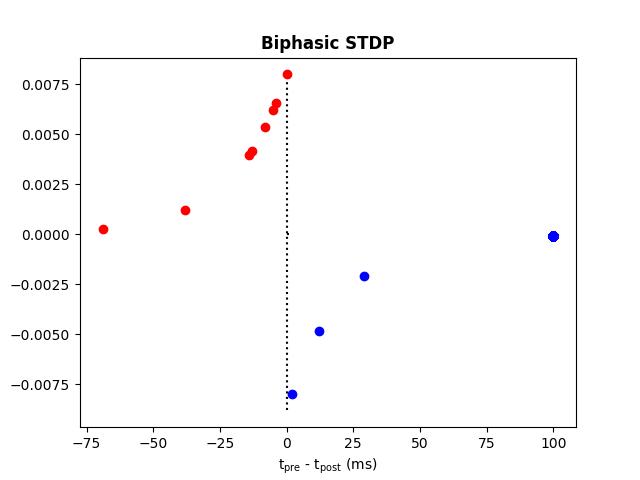

In [7]:
pre_spike_train_ex = stdp.Poisson_generator(rate=1000, n=3)
time_diff = stdp.find_nearest(pre_spike_train_ex[0], pre_spike_train_ex[1])
dW = stdp.Delta_W(time_diff)
stdp.mySTDP_plot(time_diff, dW)

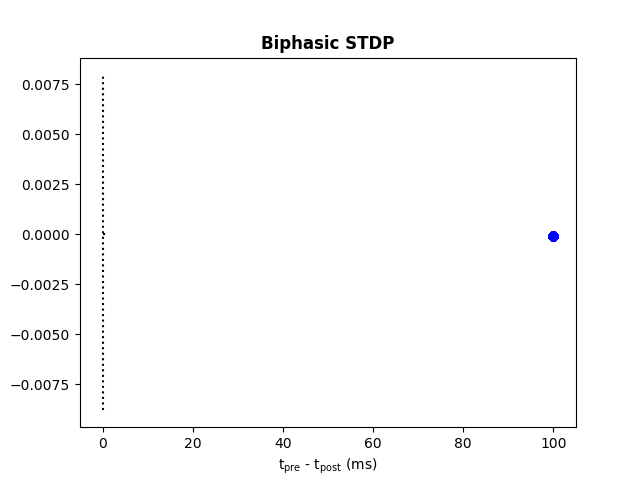

In [8]:
pre_spike_train_ex = stdp.Poisson_generator(rate=100, n=3)
time_diff = stdp.find_nearest(pre_spike_train_ex[0], pre_spike_train_ex[1])
dW = stdp.Delta_W(time_diff)
stdp.mySTDP_plot(time_diff, dW)

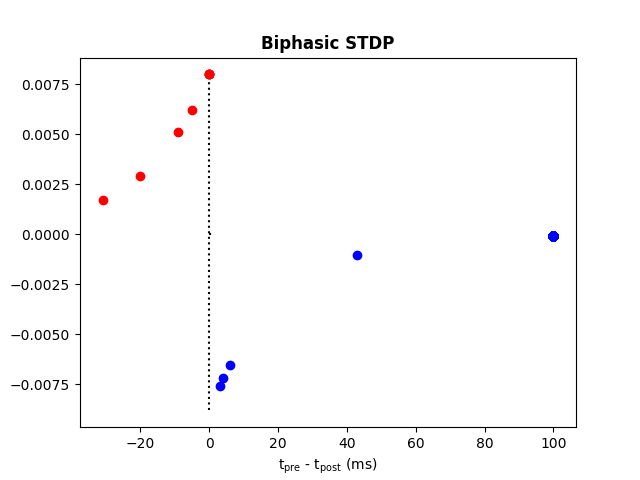

In [9]:
pre_spike_train_ex = stdp.Poisson_generator(rate=1500, n=3)
time_diff = stdp.find_nearest(pre_spike_train_ex[0], pre_spike_train_ex[1])
dW = stdp.Delta_W(time_diff)
stdp.mySTDP_plot(time_diff, dW)

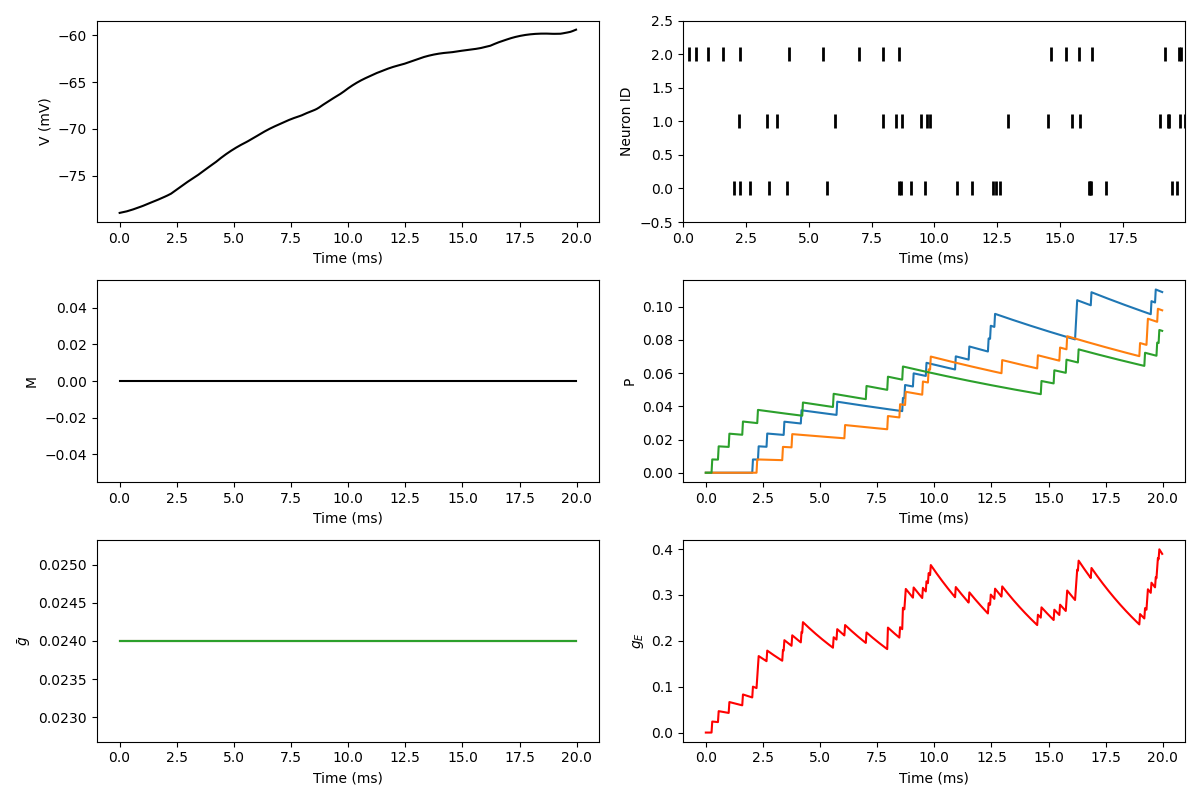

In [11]:
pre_spike_train_ex = stdp.Poisson_generator(rate=1000, n=3, myseed=2020)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = stdp.run_LIF_cond_STDP(pre_spike_train_ex)
stdp.plot_STDP(v, rec_spikes, gE, P, M, gE_bar_update)

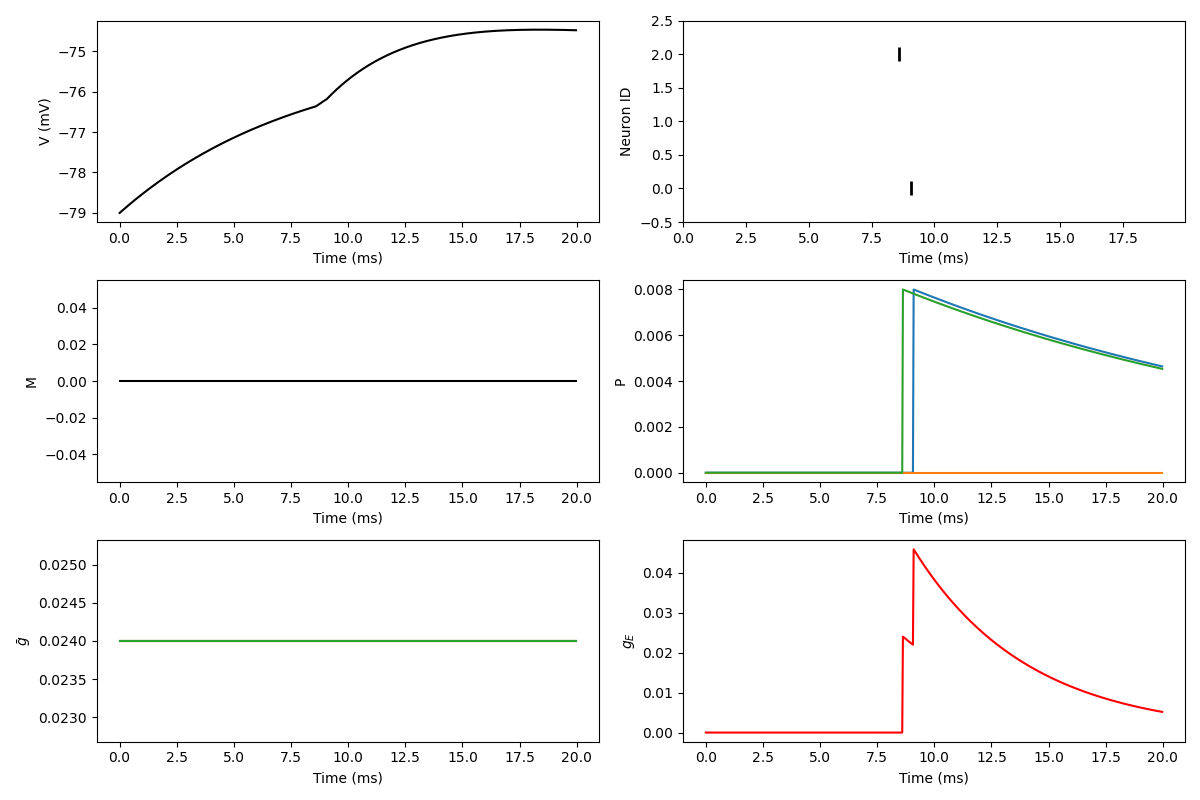

In [12]:
pre_spike_train_ex = stdp.Poisson_generator(rate=100, n=3, myseed=2020)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = stdp.run_LIF_cond_STDP(pre_spike_train_ex)
stdp.plot_STDP(v, rec_spikes, gE, P, M, gE_bar_update)

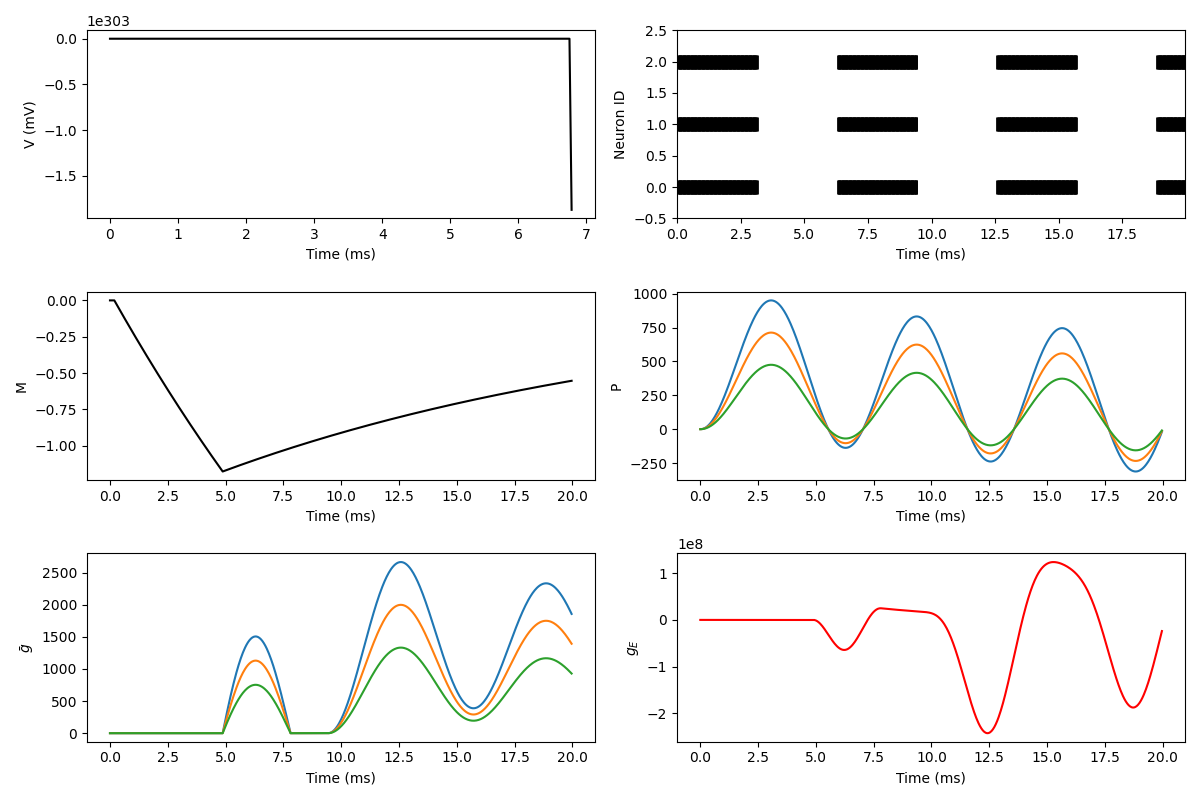

In [14]:
neurons = []
neurons.append(2000*np.sin(pars['range_t']))
neurons.append(1500*np.sin(pars['range_t']))
neurons.append(1000*np.sin(pars['range_t']))
pre_spike_train_ex = np.array(neurons)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = stdp.run_LIF_cond_STDP(pre_spike_train_ex)
stdp.plot_STDP(v, rec_spikes, gE, P, M, gE_bar_update)

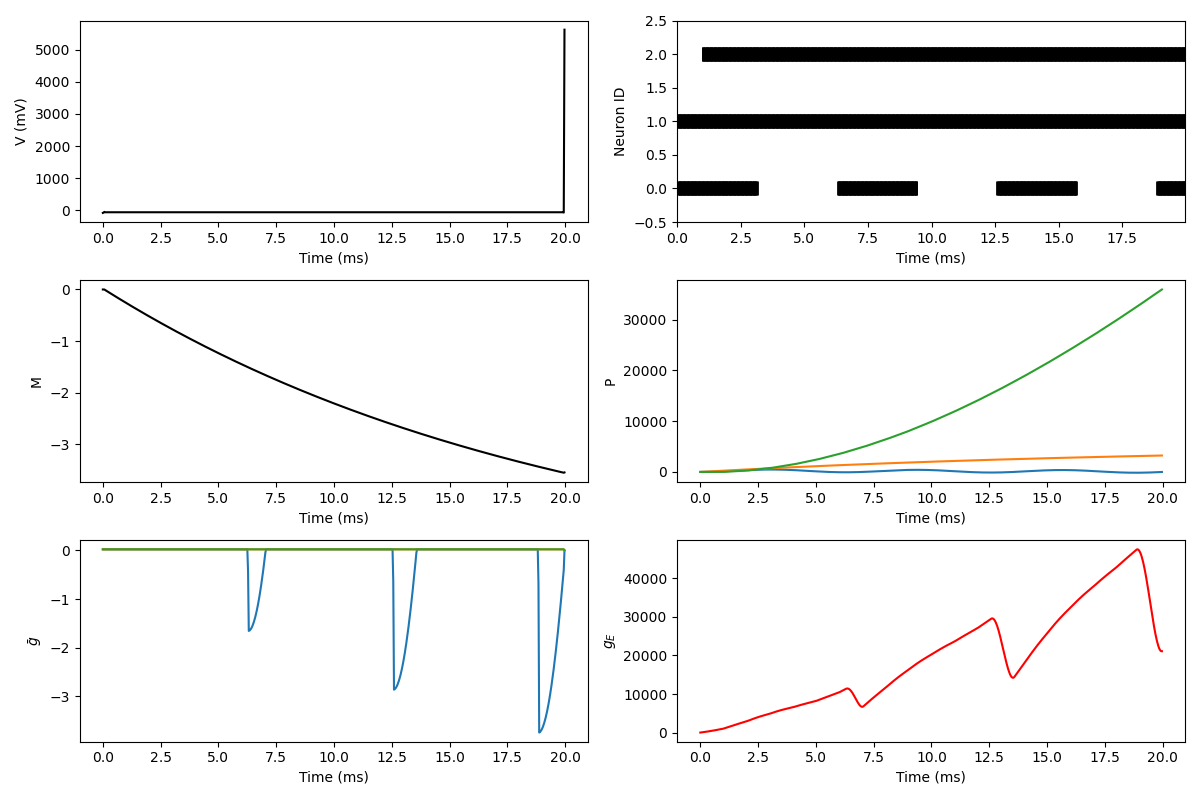

In [15]:
neurons = []
neurons.append(1000*np.sin(pars['range_t']))
neurons.append(1000*np.ones(int(pars['T']/pars['dt'])))
neurons.append(1000*np.floor(pars['range_t']))
pre_spike_train_ex = np.array(neurons)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = stdp.run_LIF_cond_STDP(pre_spike_train_ex)
stdp.plot_STDP(v, rec_spikes, gE, P, M, gE_bar_update)

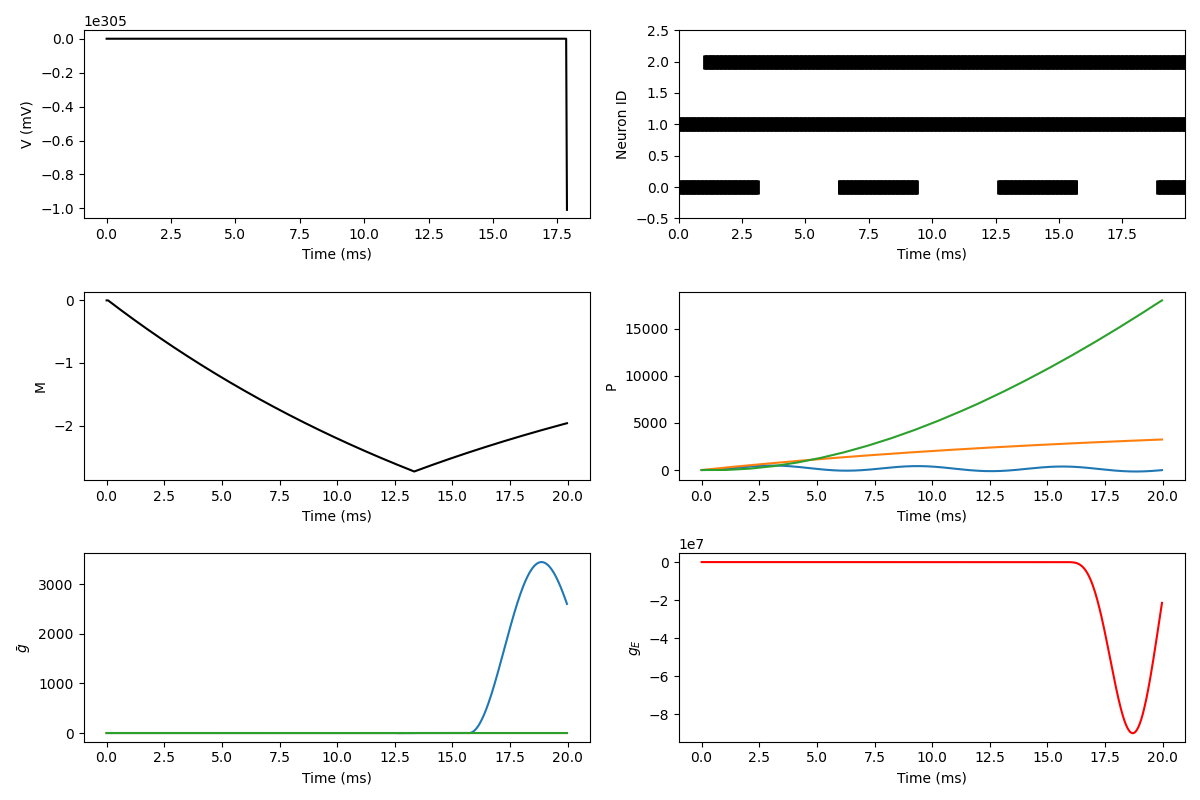

In [16]:
neurons = []
neurons.append(1000*np.sin(pars['range_t']))
neurons.append(1000*np.ones(int(pars['T']/pars['dt'])))
neurons.append(500*np.floor(pars['range_t']))
pre_spike_train_ex = np.array(neurons)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = stdp.run_LIF_cond_STDP(pre_spike_train_ex)
stdp.plot_STDP(v, rec_spikes, gE, P, M, gE_bar_update)

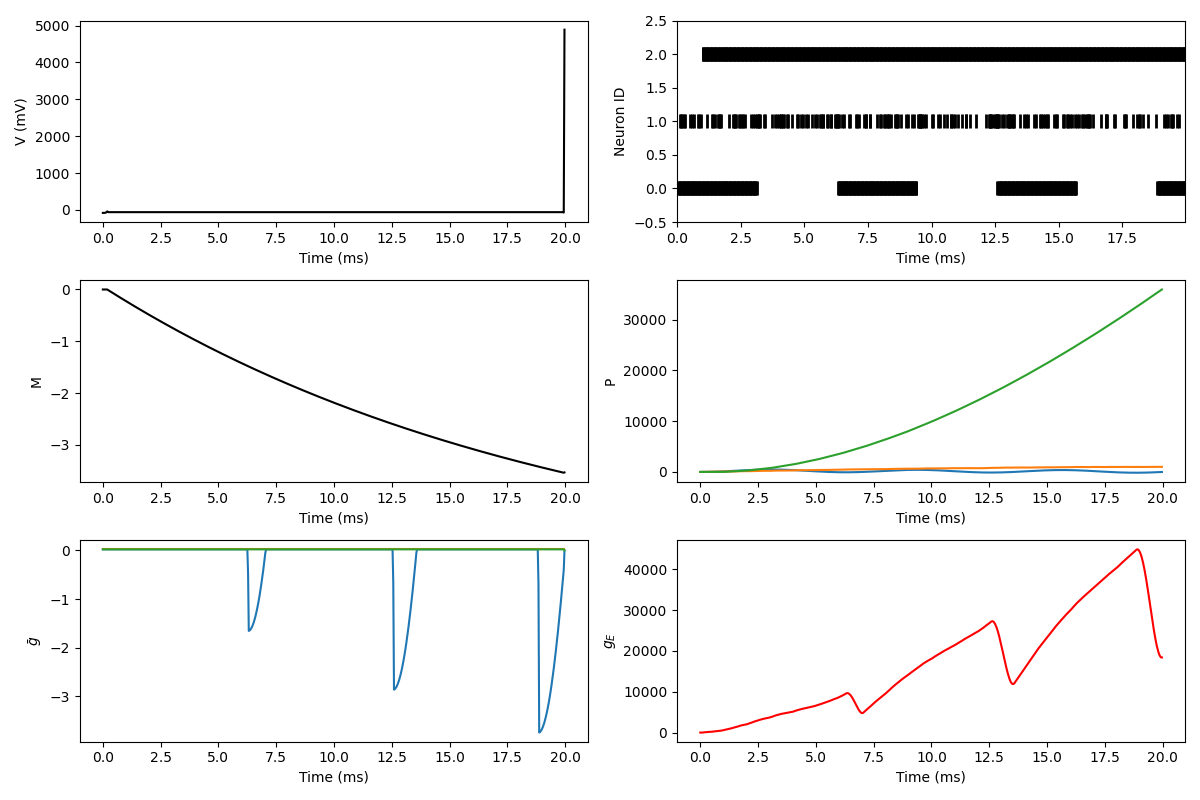

In [17]:
neurons = []
neurons.append(1000*np.sin(pars['range_t']))
neurons.append(1000*stdp.Poisson_generator(rate=10000, n=1, myseed=2020)[0])
neurons.append(1000*np.floor(pars['range_t']))
pre_spike_train_ex = np.array(neurons)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = stdp.run_LIF_cond_STDP(pre_spike_train_ex)
stdp.plot_STDP(v, rec_spikes, gE, P, M, gE_bar_update)

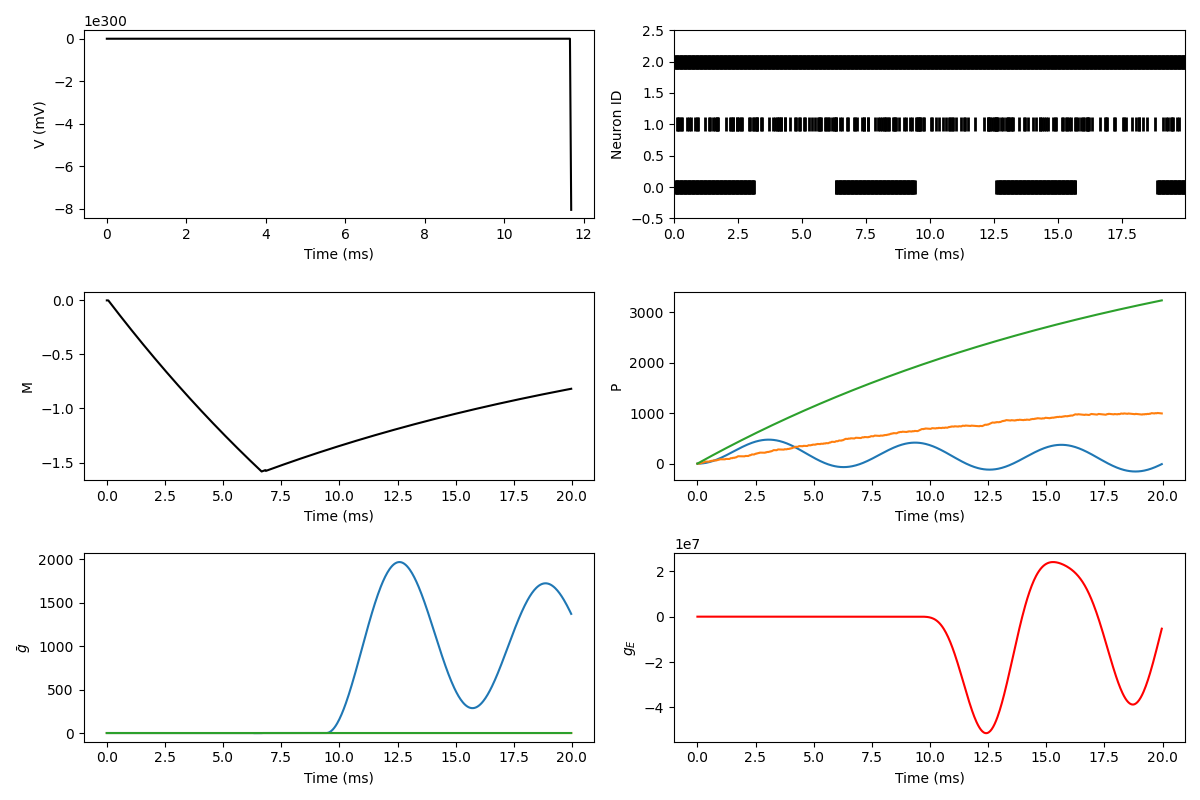

In [18]:
neurons = []
neurons.append(1000*np.sin(pars['range_t']))
neurons.append(1000*stdp.Poisson_generator(rate=10000, n=1, myseed=2020)[0])
neurons.append(1000*np.ones(int(pars['T']/pars['dt'])))
pre_spike_train_ex = np.array(neurons)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = stdp.run_LIF_cond_STDP(pre_spike_train_ex)
stdp.plot_STDP(v, rec_spikes, gE, P, M, gE_bar_update)